# Introduction

### Problem Description

Aging can be considered as a disease. From such point of view there can exist remedies for it. They are called geroprotectors. Being more rigorous, geroprotectors are drugs (or drug-like compounds) that slow down aging processes.

Species with Latin name Caenorhabiditis elegans (nematode or roundworm in English) is an object of several experiments aimed to measure effect of different drugs on mean, median, and maximum lifespan. Below these experimental data are used and further in this presentation the word 'geroprotector' means a compound that has positive impact on roundworms' lifespan.

The goal of the current study is to generate a list of compounds that are not marked as known geroprotectors, but with high probability are geroprotectors. In other words, the task is to extend given list of geroprotectors by finding new ones.

The methodology is based on PU-learning (positive vs. unlabeled learning). Unlike in the case of binary classification, there are no initially given negative examples - there are only positive and unlabeled examples. However, we treat unlabeled examples as if they were negative. This leads to irrelevance of accuracy score, because labeling a negative example with positive label can be a mistake and can be a right decision. It is better to use ROC-AUC, since it depends only on examples' ranking by probability of belonging to the positive class. Also it is sometimes possible to weight classes in order to penalize false negatives heavier than false positives. Finally, when classificator is built, negative examples with high estimated probability of positive label are delivered as new positive examples.

The main limitation of the study is that only chemical features of compounds are involved. For example, some compounds are cures if concentration is low, but become poisonous if concentration is high. However, here concentration is not used. Features derived from interaction between a drug and organism's cells are not used as well. Perhaps, this will be fixed in the future. 

### Data Sources

File *geroprotectors.csv* is based on Curated Database of Geroprotectors: http://geroprotectors.org/

File *zinc_smiles.csv* is based on ZINC Database: http://zinc.docking.org/browse/subsets/

### References

For more details on geroprotectors' search please look at:

*Moskalev A, Zhavoronkov A, et al. In search for geroprotectors: in silico screening and in vitro validation of signalome-level mimetics of young healthy state (2016).*

# Preparations

### General

In [1]:
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from rdkit.Chem import MolFromSmiles, rdMolDescriptors
from rdkit.DataStructs import ConvertToNumpyArray

In [2]:
np.random.seed(seed=361)

Of course, one can try any other random seed. Found peculiar seeds are as follows:
* 42 - one of the chosen SMILES can not be converted to fingerprint;
* 128500 - one of the chosen SMILES has the same fingerprint as a known geroprotector. 

### Data Extraction, Data Transformation, and Sanity Checkups

In [3]:
df = pd.read_csv('external_data/geroprotectors.csv', sep='\t')
df.head()

,Name,SMILES,Mean,Median,Max
0,Amoxapine,Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1,33.00,NaN,NaN
1,Amperozide Hydrochloride,Cl.CCNC(=O)N1CCN(CCCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1,38.00,NaN,NaN
2,Ascorbic Acid,OC[C@H](O)[C@H]1OC(=O)C(=C1O)O,66.67,NaN,NaN
3,Aspirin,CC(=O)Oc1ccccc1C(=O)O,23.00,NaN,NaN
4,Bacitracin,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,NaN,NaN,74.0


* Are there any duplicates?

In [4]:
len(df.index)

141

In [5]:
len(df['Name'].unique())

141

In [6]:
len(df['SMILES'].unique())

141

* How many compounds have more than one statistics measured?

In [7]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median']) & pd.notnull(df['Max'])])

2

In [8]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Median'])])

5

In [9]:
len(df[pd.notnull(df['Median']) & pd.notnull(df['Max'])])

7

In [10]:
len(df[pd.notnull(df['Mean']) & pd.notnull(df['Max'])])

20

Hence, there is not enough data to predict values of one statistic from values of another statistic.

* Are there any abnormal values?

In [11]:
df.describe()

,Mean,Median,Max
count,123.000000,20.000000,28.000000
mean,22.850488,31.879500,31.574643
std,13.247925,19.306042,22.548757
min,3.100000,10.000000,0.100000
25%,13.000000,17.600000,12.067500
50%,19.000000,23.445000,26.100000
75%,31.500000,44.250000,49.750000
max,73.330000,70.000000,78.000000


* Let us convert SMILES to binary features.

In [12]:
def smiles_to_numpy(smiles, radius=2):
    """
    Takes Morgan fingerprints for each
    element of `smiles` and packs them
    to numpy array.
    
    Morgan fingerprints are chosen,
    because they provide fixed length
    of bit vectors.
    
    @type smiles: pandas.Series
    @type radius: integer
    @return: numpy.ndarray
    """
    molecules = map(MolFromSmiles, smiles.tolist())
    to_morgan = partial(rdMolDescriptors.GetMorganFingerprintAsBitVect,
                        radius=radius)
    fingerprints = map(to_morgan, molecules)
    
    # However, RDKit does not fit in functional paradigm.
    np_fingerprints = []
    for fingerprint in fingerprints:
        arr = np.zeros((1,))
        ConvertToNumpyArray(fingerprint, arr)
        np_fingerprints.append(arr)
    result = np.vstack(tuple(np_fingerprints))
    return result

In [13]:
geroprotectors = smiles_to_numpy(df['SMILES'])
geroprotectors.shape

(141, 2048)

* Now do the same for a random collection of molecules.

In [14]:
zinc_smiles = pd.read_csv('external_data/zinc_smiles.csv')
zinc_smiles.head()

,SMILES
0,c1ccc(cc1)C(c2ccccc2)[S@](=O)CC(=O)NO
1,CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N\C(=O)OC)/[nH]2
2,c1c2c(cc3c1OCO3)[C@@H]4[C@H]([C@@H](C=C5[C@@H]...
3,C[C@@H](CC(c1ccccc1)(c2ccccc2)C(=O)N)[NH+](C)C
4,Cc1c(c(=O)n(n1C)c2ccccc2)NC(=O)[C@H](C)[NH+](C)C


In [15]:
random_indices = np.random.choice(np.arange(len(zinc_smiles.index)), size=5000, replace=False)
random_indices

array([749334, 718155, 345132, ..., 112431, 659212, 299060])

In [16]:
random_smiles = zinc_smiles.iloc[random_indices, :]
random_smiles.head()

,SMILES
749334,COc1ccc2c(c1)C(=O)NC[C@@]3(O2)CCCN(C3)C(=O)CCC...
718155,COc1ccc(cc1Cl)NC(=O)c2ccc(o2)C[NH3+]
345132,CC(=O)Nc1ccc2c(c1)[C@H]3C=CC[C@@H]3[C@@H](N2)c...
990997,c1cc(oc1)CC[C@@H](C[P@@H](=O)[O-])c2ccco2
605526,COc1ccc(cc1)CNC(=O)CCc2nc3ccccc3o2


In [17]:
len(random_smiles['SMILES'].unique())

5000

In [18]:
random_compounds = smiles_to_numpy(random_smiles['SMILES'])
random_compounds.shape

(5000, 2048)

* Are there any duplicates (not for SMILES, but for fingerprints)? Do samples overlap?

In [19]:
unique_gp = np.vstack({tuple(row) for row in geroprotectors}).shape[0]

try:
    assert unique_gp == geroprotectors.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for geroprotectors: {}.".format(
        geroprotectors.shape[0] - unique_gp)
else:
    print "There are no duplicated fingerprints for geroprotectors."

There are no duplicated fingerprints for geroprotectors.


In [20]:
unique_rc = np.vstack({tuple(row) for row in random_compounds}).shape[0]

try:
    assert unique_rc == random_compounds.shape[0]
except AssertionError:
    print "# of duplicated fingerprints for random compounds: {}.".format(
        random_compounds.shape[0] - unique_rc)
else:
    print "There are no duplicated fingerprints for random compounds."

# of duplicated fingerprints for random compounds: 11.


In [21]:
unique_all = np.vstack({tuple(row)
                        for row in np.vstack((geroprotectors, random_compounds))}).shape[0]

try:
    assert unique_all == unique_gp + unique_rc
except AssertionError:
    print "Length of intersection between two samples: {}.".format(
        unique_gp + unique_rc - unique_all)
else:
    print "There is no intersection between geroprotectors and random compounds."

There is no intersection between geroprotectors and random compounds.


Although *random_compounds* has duplicate fingerprints (e.g. due to hash collisions turning different SMILES into the same fingerprint), there is an empty intersection between randomly chosen compounds and known geroprotectors.

* Finally, gather samples together and introduce the target variable.

In [22]:
positives = np.hstack((geroprotectors, np.ones((geroprotectors.shape[0], 1))))
negatives = np.hstack((random_compounds, np.zeros((random_compounds.shape[0], 1))))
sample = np.vstack((positives, negatives))
sample.shape

(5141, 2049)

In [23]:
border = positives.shape[0]

# Exploratory Analysis

### Single Bits Importance

Below hypothesis that some bits of fingerprints allows separating geroprotectors, is tested.

In [24]:
scores = {}
for i in range(sample.shape[1] - 1):
    scores[i] = roc_auc_score(sample[:, -1], sample[:, i])

In [25]:
n_to_print = 10
for position in sorted(scores, key=scores.get, reverse=True)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1602, ROC-AUC: 0.587775177305
Bit position: 1607, ROC-AUC: 0.57365248227
Bit position: 389, ROC-AUC: 0.565090070922
Bit position: 1844, ROC-AUC: 0.557883687943
Bit position: 352, ROC-AUC: 0.556360283688
Bit position: 1979, ROC-AUC: 0.555337588652
Bit position: 1538, ROC-AUC: 0.555237588652
Bit position: 1257, ROC-AUC: 0.553629787234
Bit position: 222, ROC-AUC: 0.553275886525
Bit position: 1171, ROC-AUC: 0.551990780142


In [26]:
for position in sorted(scores, key=scores.get)[:n_to_print]:
    print "Bit position: {}, ROC-AUC: {}".format(position, scores[position])

Bit position: 1152, ROC-AUC: 0.321375177305
Bit position: 378, ROC-AUC: 0.350321985816
Bit position: 1917, ROC-AUC: 0.363258156028
Bit position: 1816, ROC-AUC: 0.373992198582
Bit position: 1057, ROC-AUC: 0.385465248227
Bit position: 1750, ROC-AUC: 0.393533333333
Bit position: 1722, ROC-AUC: 0.39729929078
Bit position: 650, ROC-AUC: 0.399125531915
Bit position: 1873, ROC-AUC: 0.415270921986
Bit position: 1380, ROC-AUC: 0.41904751773


After reverting predictions ROC-AUC over 67% is reached solely by feature 1152 for all tested random seeds. They are as follows: 19, 26, 44, 123, 187, 361, 638, 1001, 3249, 128500.

In [27]:
np.mean(positives[:, 1152])

0.22695035460992907

In [28]:
np.mean(negatives[:, 1152])

0.58420000000000005

Thus, there is no silver bullet amongst the features, but there are relationships between the target and the features.

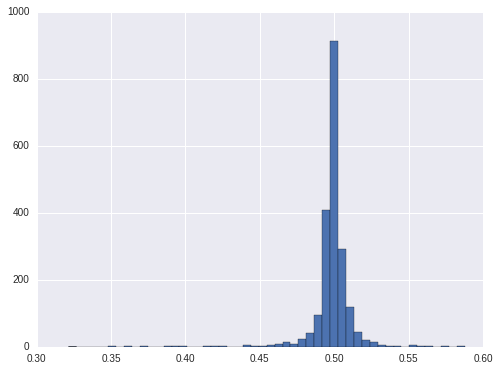

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
_ = ax.hist([scores[key] for key in scores.keys()], 50)

More than half of the features seem like they are useless. The next section surveys effect of their removal as well as some other issues.

### Similarities' Study

In [30]:
def take_balanced_subsample(iterable, size):
    """
    For each element of `iterable` samples
    `size` objects (i.e. lines) from it and then
    concatenates the results.
    
    @type iterable: list-like of numpy.ndarray
    @type size: integer
    @type: numpy.ndarray
    """
    subsamples = []
    for arr in iterable:
        subsample = arr[np.random.choice(np.arange(arr.shape[0]), size=size, replace=False), :]
        subsamples.append(subsample)
    return np.vstack(tuple(subsamples))

In [31]:
def tanimoto_similarity(first, second):
    """
    Computes Tanimoto similarity of two arrays.
    
    It is defined as a ratio of number of bits
    active in both arrays to number of bits
    active in at least one array.
    
    @type first: numpy.ndarray
    @type second: numpy.ndarray
    @return: float
    """
    bool_first = first.astype(bool)
    bool_second = second.astype(bool)
    intersection_length = np.sum(np.bitwise_and(bool_first, bool_second).astype(int))
    union_length = np.sum(np.bitwise_or(bool_first, bool_second).astype(int))
    return float(intersection_length) / union_length

In [32]:
def fill_tanimoto_matrix(arr):
    """
    Assuming that each line of `arr` represents
    an object, fills matrix of pairwise
    Tanimoto similarities.
    
    @type arr: numpy.ndarray
    @return: numpy.ndarray
    """
    size = arr.shape[0]
    tanimoto_matrix = np.zeros((size, size))
    for i, j in product(range(size), range(size)):
        tanimoto_matrix[i, j] = tanimoto_similarity(arr[i, :], arr[j, :])
    return tanimoto_matrix

In [33]:
halfsize = 10
subsample = take_balanced_subsample([positives, negatives], halfsize)[:, :-1]
tanimoto_matrix = fill_tanimoto_matrix(subsample)

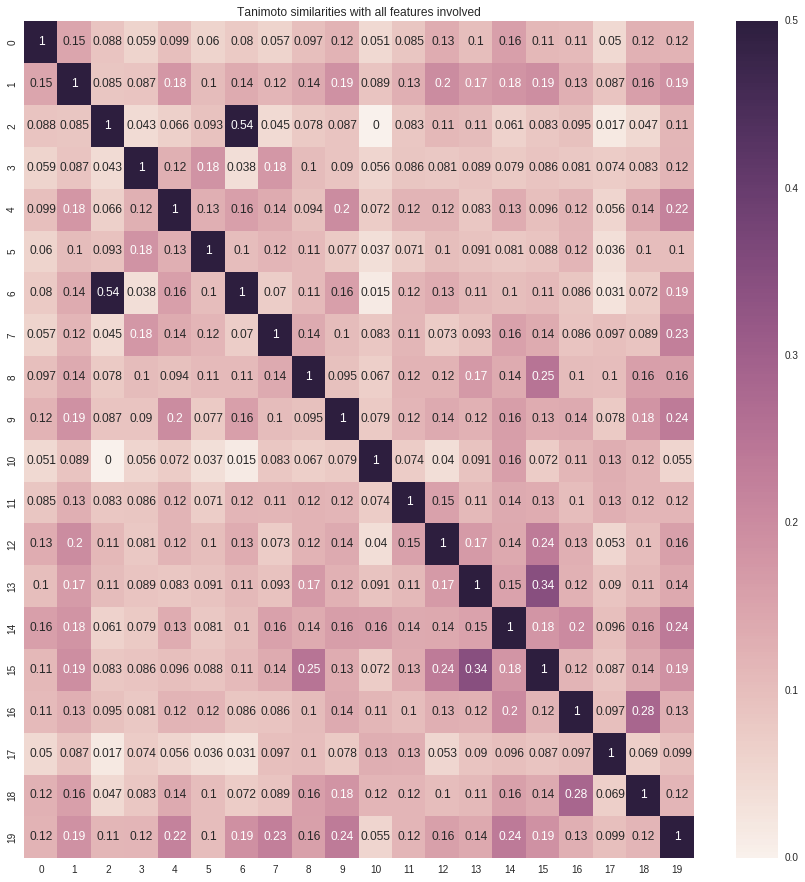

In [34]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Tanimoto similarities with all features involved")
_ = sns.heatmap(tanimoto_matrix, ax=ax, annot=True, vmax=0.5)

In [35]:
relevant_features = [key for key in scores.keys() if abs(scores[key] - 0.5) > 0.01]
subspaced_subsample = subsample[:, relevant_features]
subspaced_tanimoto_matrix = fill_tanimoto_matrix(subspaced_subsample)

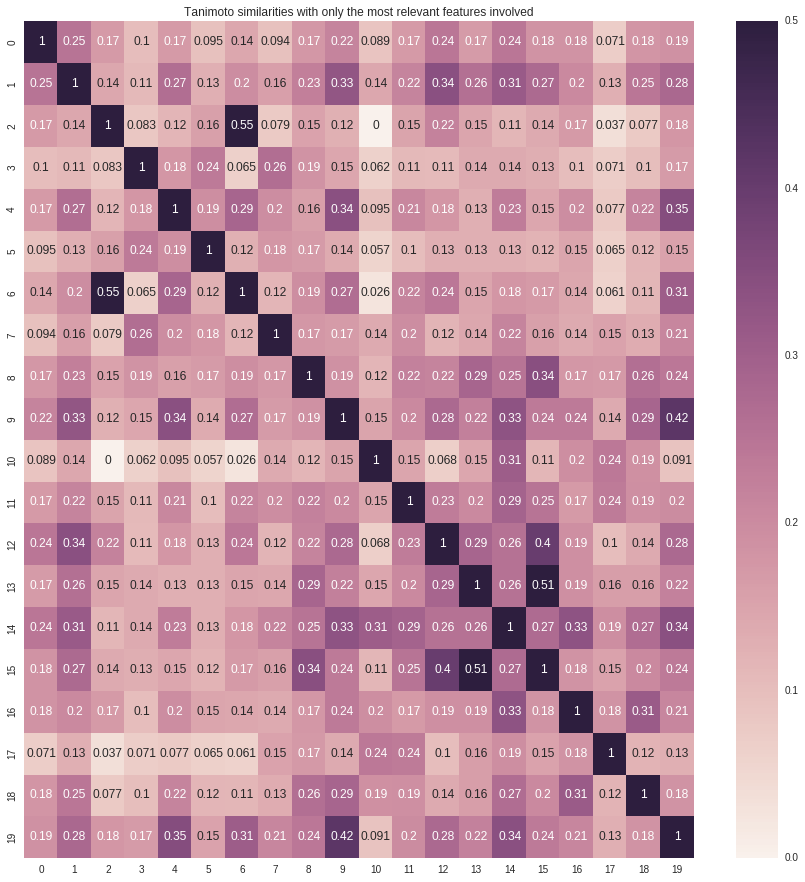

In [36]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Tanimoto similarities with only the most relevant features involved")
_ = sns.heatmap(subspaced_tanimoto_matrix, ax=ax, annot=True, vmax=0.5)

It can be seen that removal of weak features makes compounds more similar to each other.

Also it is clear from the heatmaps that known geroprotectors are dissimilar to each other approximately at the same extent as they are dissimilar to random compounds.

### Dimensionality Reduction

The trick applied here is that instead of dropping irrelevant features all features are weighted according to their relevance. If features are binary, PCA treats all of them as equally important, but suggested trick solves this issue.

In [37]:
weights = np.array([abs(scores[key] - 0.5) for key in scores.keys()])
weighted_positives = positives[:, :-1] * weights
weighted_negatives = negatives[:, :-1] * weights
weighted_sample = sample[:, :-1] * weights

In [38]:
pca = PCA(n_components=10, random_state=361)
pca.fit(weighted_sample)
pca.explained_variance_ratio_

array([ 0.249474  ,  0.13769388,  0.0764098 ,  0.06983147,  0.05185634,
        0.03839376,  0.03516741,  0.03218909,  0.02282965,  0.01813438])

In [39]:
pca = PCA(n_components=1, random_state=361)
roc_auc_score(sample[:, -1], pca.fit_transform(weighted_sample)[:, 0])

0.72270070921985818

In [40]:
pca = PCA(n_components=3, random_state=361)
pca.fit(weighted_sample)
pcaed_positives = pca.transform(weighted_positives)
pcaed_negatives = pca.transform(weighted_negatives)

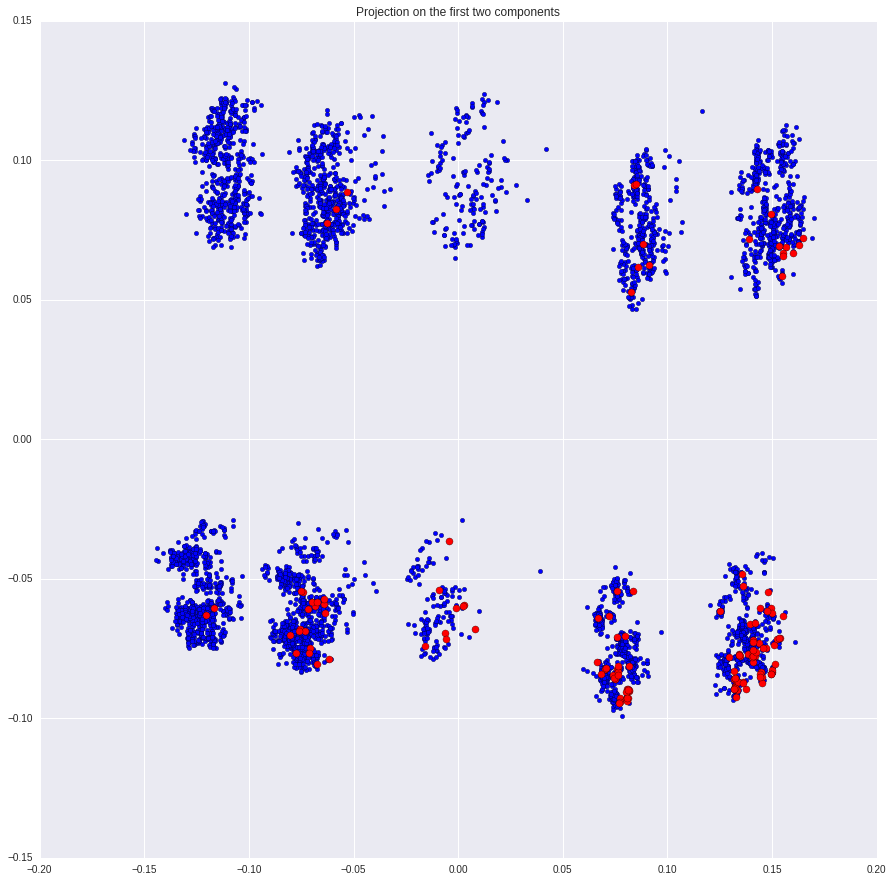

In [41]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the first two components")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 1])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 1], c='Red', s=50)

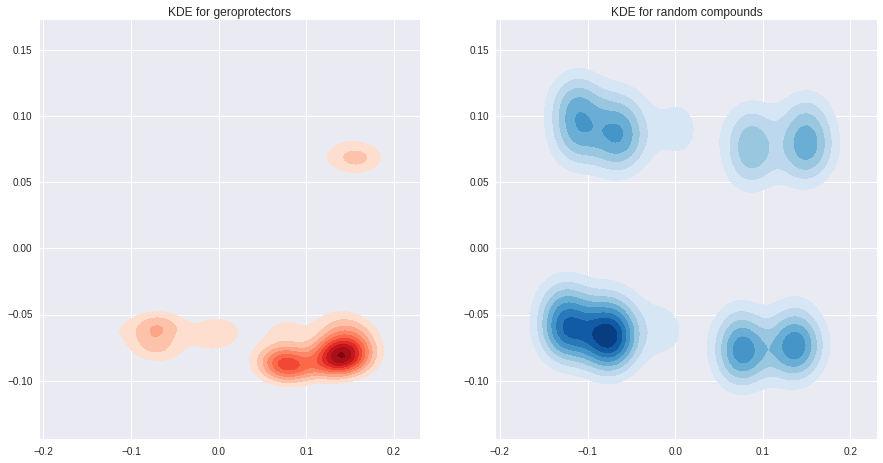

In [42]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
sns.kdeplot(pcaed_positives[:, 0], pcaed_positives[:, 1],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
_ = sns.kdeplot(pcaed_negatives[:, 0], pcaed_negatives[:, 1],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

Above graph can be used for extending the list of geroprotectors. There is a hypothesis that the majority of random compounds from the bottom right cluster (i.e. the one with center at (0.13, -0.07)) are geroprotectors. This hypothesis seems very plausible.

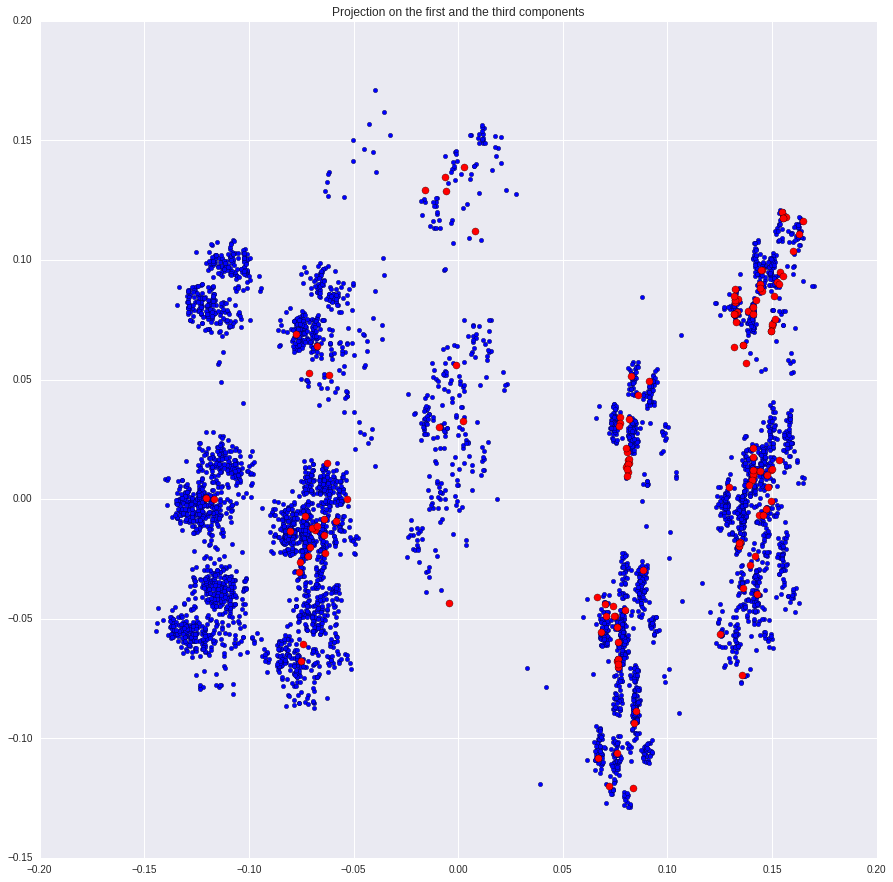

In [43]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the first and the third components")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 2], c='Red', s=50)

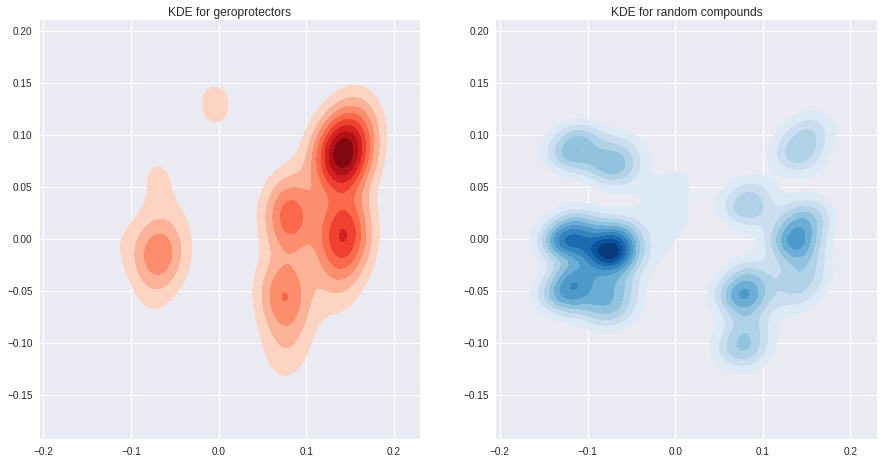

In [44]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
sns.kdeplot(pcaed_positives[:, 0], pcaed_positives[:, 2],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
_ = sns.kdeplot(pcaed_negatives[:, 0], pcaed_negatives[:, 2],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

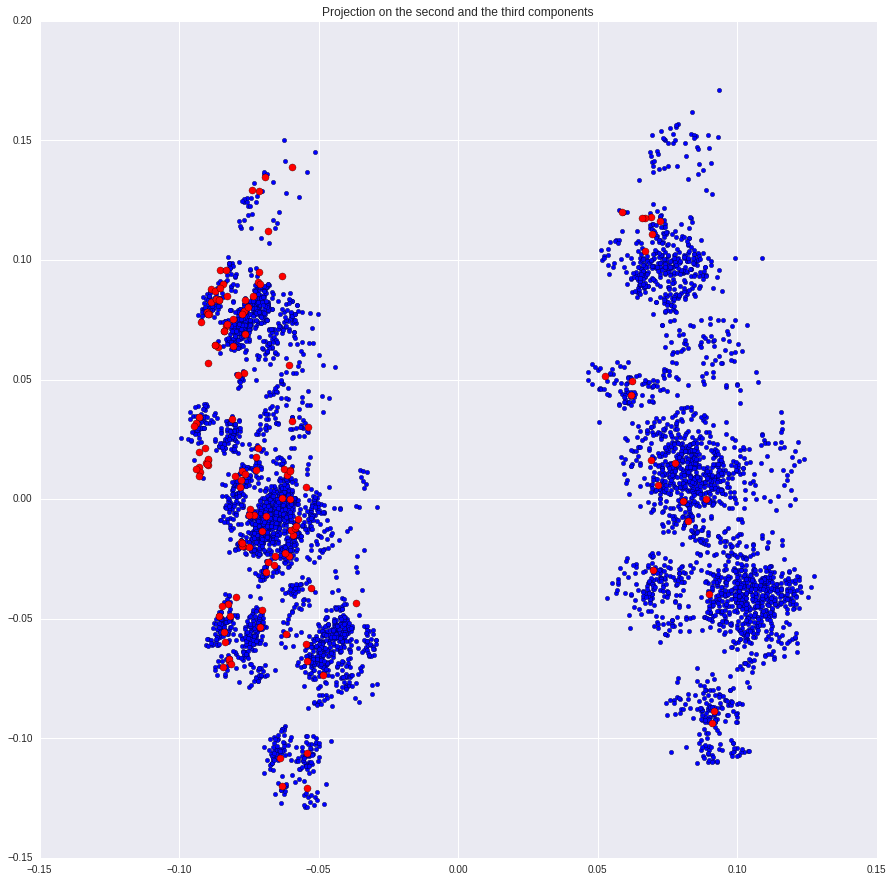

In [45]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.set_title("Projection on the second and the third components")
ax.scatter(pcaed_negatives[:, 1], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 1], pcaed_positives[:, 2], c='Red', s=50)

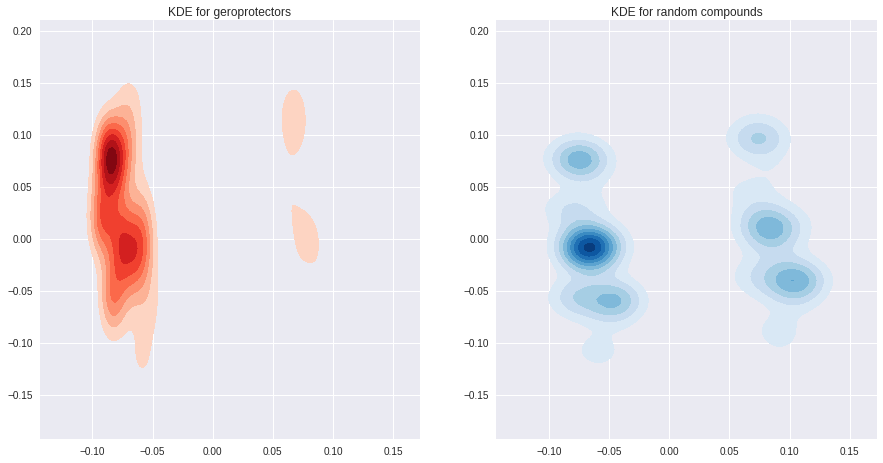

In [46]:
fig = plt.figure(figsize=(15, 7.5))
ax_one = fig.add_subplot(121)
ax_one.set_title("KDE for geroprotectors")
sns.kdeplot(pcaed_positives[:, 1], pcaed_positives[:, 2],
            cmap='Reds', shade=True, shade_lowest=False, ax=ax_one)
ax_two = fig.add_subplot(122, sharex=ax_one, sharey=ax_one)
ax_two.set_title("KDE for random compounds")
_ = sns.kdeplot(pcaed_negatives[:, 1], pcaed_negatives[:, 2],
            cmap='Blues', shade=True, shade_lowest=False, ax=ax_two)

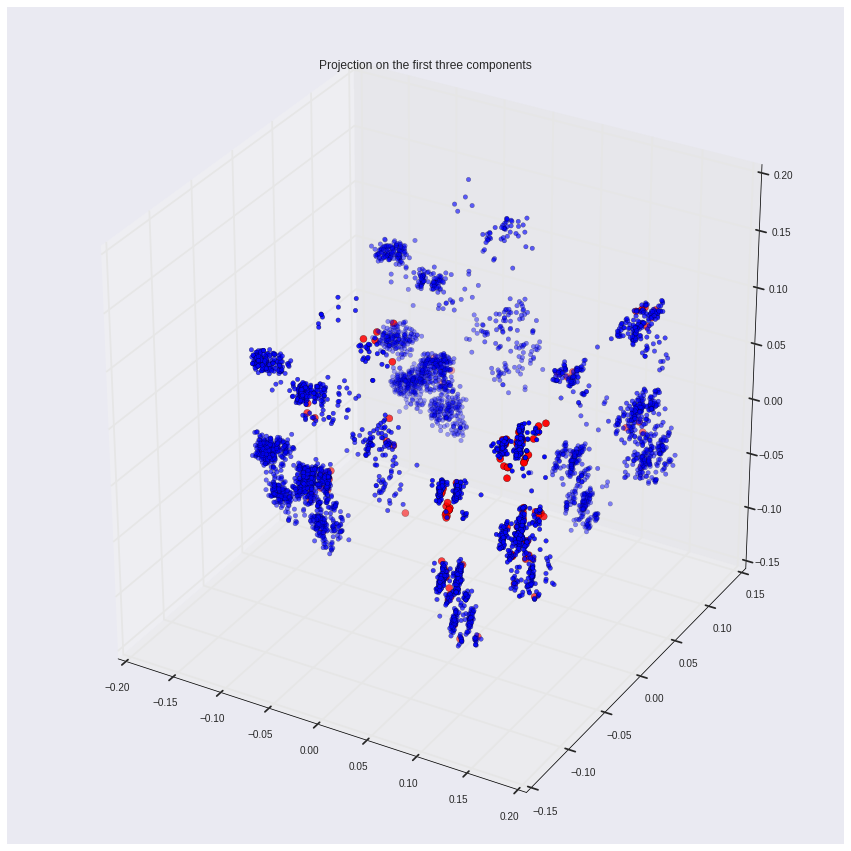

In [47]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Projection on the first three components")
ax.scatter(pcaed_negatives[:, 0], pcaed_negatives[:, 1], pcaed_negatives[:, 2])
_ = ax.scatter(pcaed_positives[:, 0], pcaed_positives[:, 1], pcaed_positives[:, 2],
               c='Red', s=50)

The conclusion is that there are clusters with high concentration of known geroprotectors and low concentration of unlabeled compounds. Unlabeled compounds from such clusters are potential geroprotectors.

# Splitting Data, Feature Engeneering and Feature Selection

In [48]:
X = sample[:, :-1]
y = sample[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=361)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3855, 2048), (1286, 2048), (3855,), (1286,))

In [49]:
np.sum(y_train) / y_train.shape[0], np.sum(y_test) / y_test.shape[0]

(0.027496757457846951, 0.027216174183514776)

To generate PCA-based features, *y_test* can not be used and *X_test* can be transformed, but it is better to avoid fitting PCA to it.

In [50]:
scores = {}
for i in range(X_train.shape[1]):
    scores[i] = roc_auc_score(y_train, X_train[:, i])
weights = np.array([abs(scores[key] - 0.5) for key in scores.keys()])
weighted_X_train = X_train * weights
weighted_X_test = X_test * weights

In [51]:
pca = PCA(n_components=50, random_state=361)
pca.fit(weighted_X_train)
evr = pca.explained_variance_ratio_

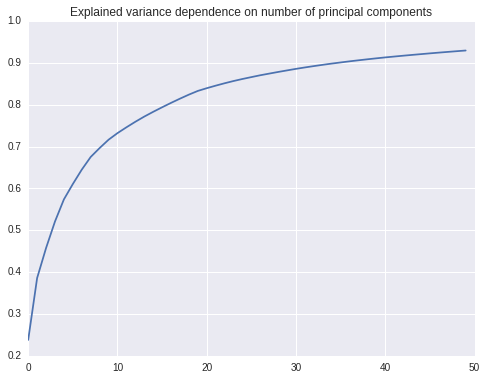

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title("Explained variance dependence on number of principal components")
_ = ax.plot(evr.cumsum())

Thus, the most informative components are the first three components. However, they explain not so many variance and because of this it is better to include the first 20 components. 

In [ ]:
pca = PCA(n_components=20, random_state=361)
pca.fit(weighted_X_train)
pcaed_X_train = pca.transform(weighted_X_train)
pcaed_X_test = pca.transform(weighted_X_test)

In [ ]:
for i in range(3):
    raw_train = roc_auc_score(y_train, pcaed_X_train[:, i])
    raw_test = roc_auc_score(y_test, pcaed_X_test[:, i])
    print "Univariate ROC-AUC for component {}; train: {}, test: {}".format(
        i, max(raw_train, 1 - raw_train), max(raw_test, 1 - raw_test))

These univariate benchmarks look quite decent, but not perfect. Anyway, this is enough to include the corresponding features.

Now filter irrelevant initial features based on Pearson's $\chi^2$-test. It is appropriate here, because features are Boolean.

How to choose a number of features to be selected? There is a heuristic that it is desirable to have at least 30 observations per each independent variable. Given 20 principal components and approximately 5100 training examples, an estimation of number of features is: $$(0.8 \times 0.75 \times 5100) \,/ \, 30 - 20 \approx 80,$$ where factors in numerator adjust for train-test splitting and cross-validation.

In [ ]:
feature_selector = SelectKBest(chi2, k=80)
subspaced_X_train = feature_selector.fit_transform(X_train, y_train)
subspaced_X_test = feature_selector.transform(X_test)

In [ ]:
X_train = np.hstack((subspaced_X_train, pcaed_X_train))
X_test = np.hstack((subspaced_X_test, pcaed_X_test))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Modelling

### K-Nearest Neighbors

In [ ]:
clf = KNeighborsClassifier()
grid_params = {'n_neighbors': [20, 30, 40, 50],
               'weights': ['uniform', 'distance'],
               'p': [1, 2]}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=361)
grid_search_clf = GridSearchCV(clf, grid_params, cv=kf, scoring='roc_auc', refit=False)

Because K-nearest neighbors classifier is vulnerable to curse of dimensionality, only few features are used. 

In [ ]:
dimensions = {}
for n_components in range(1, 4):
    print "-*- Results for number of components: {}".format(n_components)
    grid_search_clf.fit(pcaed_X_train[:, :n_components], y_train)
    dimensions[n_components] = grid_search_clf.best_score_
    print "Best cross-validation mean score: {}".format(grid_search_clf.best_score_)
    means = grid_search_clf.cv_results_['mean_test_score']
    stds = grid_search_clf.cv_results_['std_test_score']
    print "Detailed results:"
    for mean, std, params in zip(means, stds, grid_search_clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, 2 * std, params))
    print ''

In [ ]:
grid_search_clf = GridSearchCV(clf, grid_params, cv=kf, scoring='roc_auc')

best_dim = max(dimensions, key=dimensions.get)
grid_search_clf.fit(pcaed_X_train[:, :best_dim], y_train)

clf = grid_search_clf.best_estimator_

In [ ]:
y_test_hat = clf.predict_proba(pcaed_X_test[:, :best_dim])
roc_auc_score(y_test, y_test_hat[:, 1])

In [ ]:
# To be continued.